In [2]:
from functools import partial
import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd

from circuit_sim import circuit_sim

ic_list = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 150, 213]
vb_list = [0.50e-3, 2.50e-3]
bc_list = [2]
tot_combi = len(ic_list) * len(vb_list) * len(bc_list)
indices = range(1, tot_combi + 1)

def strParse(index, tot_combi):
    vb_tag = 0 if index <= (tot_combi/2) else 1
    bc_tag = 0
    # bc_tag = 0 if (index <= (tot_combi/4) or index > (tot_combi*3/4)) else 1
    vb = vb_list[vb_tag]
    bc = bc_list[bc_tag]
    # Ic = ic_list[(index % len(ic_list)) - 1]
    Ic = ic_list[(index - 1) % len(ic_list)]
    return vb, bc, Ic

def run_simulation(i):
    vb, bc, Ic = strParse(i, tot_combi)
    Ic_scale = Ic / 213
    Vb_scale = vb / 2.50e-3
    
    sim_con = circuit_sim("sfq-jtl-axsfq.jsm")
    sim_con.change_Ic_sfq(Ic_scale)
    sim_con.change_Vb_sfq(Vb_scale)
    sim_con.change_temp(0)
    sim_con.sim()

    res_start = sim_con.get_switch_timing_sfq(["P(B2|X8|X34)"])
    res_fin = sim_con.get_switch_timing_sfq(["P(B1|X1|X41)"])
    diff1 = res_fin["time"].iloc[0] - res_start["time"].iloc[0]
    per_jj = diff1 / 80  # ps per JJ
    return per_jj

In [3]:
if __name__ == "__main__":
    res_df = pd.DataFrame(columns=["Idx","Ic_uA","Vb_mV","Betac","ps_per_JJ"])
    max_workers = int(multiprocessing.cpu_count()/2)
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(run_simulation, i): i for i in indices}
        for future in as_completed(futures):
            index = futures[future]
            try:
                ps_per_JJ = future.result()
                vb, bc, Ic = strParse(index, tot_combi)
                res_df = pd.concat([res_df, pd.DataFrame({
                    "Idx": [index],
                    "Ic_uA": [Ic],
                    "Vb_mV": [vb*1e3],
                    "Betac": [bc],
                    "ps_per_JJ": [ps_per_JJ]
                })], ignore_index=True)
            except Exception as e:
                print(f"Index {index} generated an exception: {e}")
    res_df = res_df.sort_values(by=["Idx"]).reset_index(drop=True)
    print(res_df)

   Idx Ic_uA  Vb_mV Betac     ps_per_JJ
0    1     2    0.5     2  2.570500e-12
1    2     3    0.5     2  2.570500e-12
2    3     4    0.5     2  2.570500e-12
3    4     5    0.5     2  2.570500e-12
4    5     8    0.5     2  2.570500e-12
5    6    10    0.5     2  2.570500e-12
6    7    15    0.5     2  2.570500e-12
7    8    20    0.5     2  2.570500e-12
8    9    25    0.5     2  2.570500e-12
9   10    30    0.5     2  2.570500e-12
10  11    35    0.5     2  2.570500e-12
11  12    40    0.5     2  2.570500e-12
12  13    50    0.5     2  2.570500e-12
13  14    60    0.5     2  2.570500e-12
14  15    70    0.5     2  2.570500e-12
15  16    80    0.5     2  2.570500e-12
16  17    90    0.5     2  2.570500e-12
17  18   100    0.5     2  2.570500e-12
18  19   150    0.5     2  2.570500e-12
19  20   213    0.5     2  2.570500e-12
20  21     2    2.5     2  1.798750e-12
21  22     3    2.5     2  1.798750e-12
22  23     4    2.5     2  1.798750e-12
23  24     5    2.5     2  1.798750e-12


/tmp/ipykernel_2379094/3700751148.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


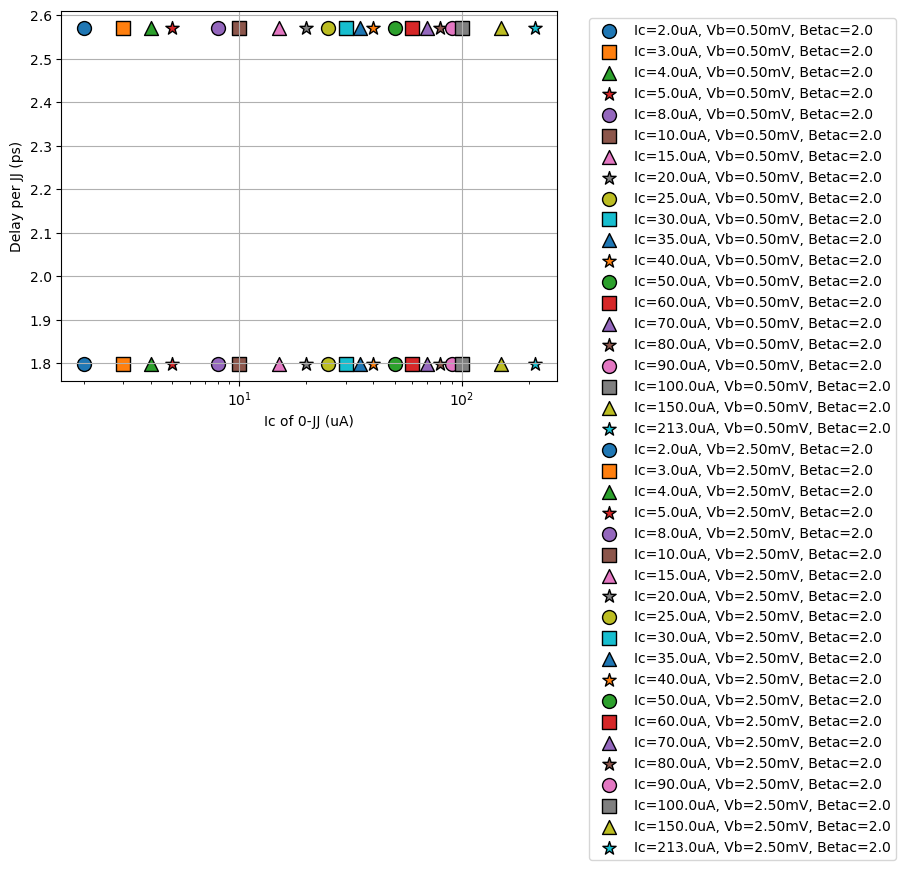

In [4]:
import matplotlib.pyplot as plt

marker_styles = ['o', 's', '^', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# marker_styles = ['o', 's', '^', 'v', '<', '>', 'x', '+', '*', 'D']
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray']

plt.figure()
for i in range(len(res_df["Idx"])):
    marker_map = i % len(marker_styles)
    # color_map = int(i / int(tot_combi/len(ic_list)))
    Ic = res_df["Ic_uA"].iloc[i]
    Vb = res_df["Vb_mV"].iloc[i]
    Betac = res_df["Betac"].iloc[i]
    delay = res_df["ps_per_JJ"].iloc[i]
    label = f"Ic={Ic:.1f}uA, Vb={Vb:.2f}mV, Betac={Betac:.1f}"
    plt.scatter(Ic, delay*1e12, marker=marker_styles[marker_map], label=label, s=100, edgecolors='black')
# plt.xlim(15, 23)
# plt.ylim(3.5, 3.6)
plt.xscale("log")
plt.xlabel("Ic of 0-JJ (uA)")
plt.ylabel("Delay per JJ (ps)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()  

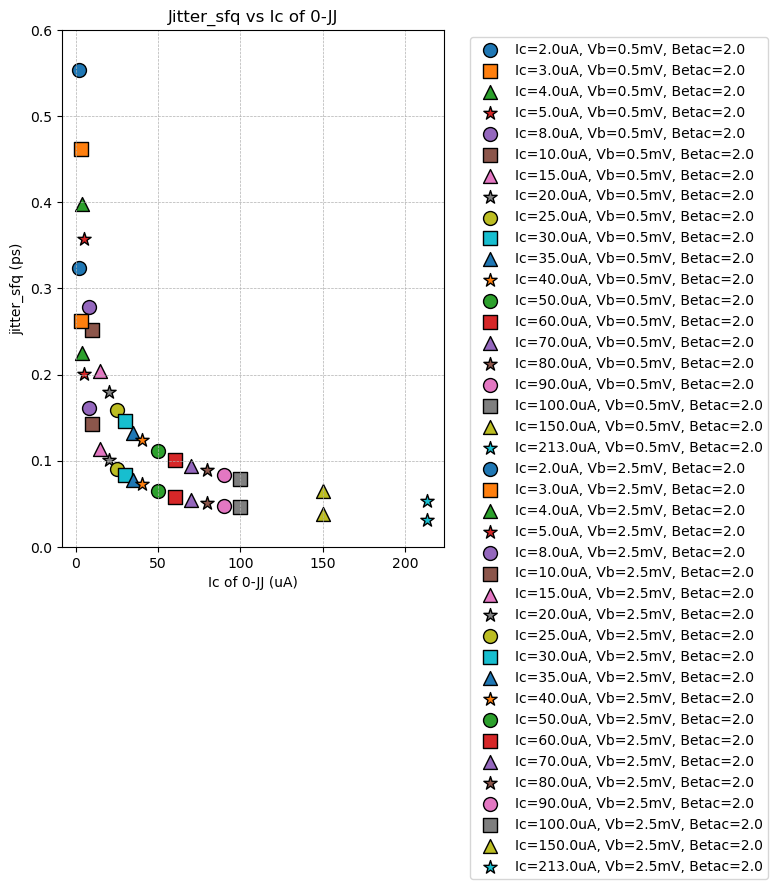

In [7]:
# (2)
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

ic_list = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 150, 213]
vb_list = [0.50e-3, 2.50e-3]
bc_list = [2]
tot_combi = len(ic_list) * len(vb_list) * len(bc_list)
indices = range(1, tot_combi + 1)

plt.rcParams['font.family'] = ''
open("jitter_sfq_lv.csv", "w").close()
xy_data = pd.DataFrame(columns=["Name", "Ic", "Vb", "Betac", "Std"])
for i in indices:
    vb, bc, Ic = strParse(i, tot_combi)
    diff_file = f"jitter_sfq_lv/diff_{i}.csv"
    data = pd.read_csv(diff_file)
    mu, std = norm.fit(data)
    std_per_jj = math.sqrt(std*std/80)
    name = f"Ic={Ic:.1f}uA, Vb={vb*1e3:.1f}mV, Betac={bc:.1f}"
    xy_data = pd.concat([xy_data, pd.DataFrame([[name, Ic, vb, bc, std_per_jj]], columns=["Name", "Ic", "Vb", "Betac", "Std"])], ignore_index=True)

    with open("jitter_sfq_lv.csv", "a") as f:
        f.write(f"{Ic},{vb},{bc},{std_per_jj}\n")
        
    # fig = plt.figure()
    # plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label="Histogram")
    # xmin, xmax = plt.xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # plt.plot(x, p, 'r', linewidth=2, label="Fitted Normal Distribution")
    # plt.xlabel("Jitter_sfq Value")
    # plt.ylabel("Density")
    # plt.title("Fractuation of Propagation Time")
    # plt.legend()
    # plt.savefig(f"jitter_sfq/jitter_sfq_{i}.png")
    # # plt.show()
    # plt.close()

marker_styles = ['o', 's', '^', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig = plt.figure(figsize=(8, 8))
for idx, row in xy_data.iterrows():
    marker_map = idx % len(marker_styles)
    # color_map = int(idx / int(len(xy_data)/len(lic_list)))
    if row["Vb"] == 0.50e-3 or row["Vb"] == 2.50e-3:
        plt.scatter(row["Ic"], row["Std"]*1e12, label=row["Name"],
                    marker=marker_styles[marker_map],
                    s=100,
                    # color = colors[color_map],
                    edgecolors='black',
                    alpha=1.0,
                    )
    
# plt.xlim(0, 35)
plt.ylim(0, 0.6)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title('Jitter_sfq vs Ic of 0-JJ')
plt.xlabel('Ic of 0-JJ (uA)')
plt.ylabel('jitter_sfq (ps)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.close()

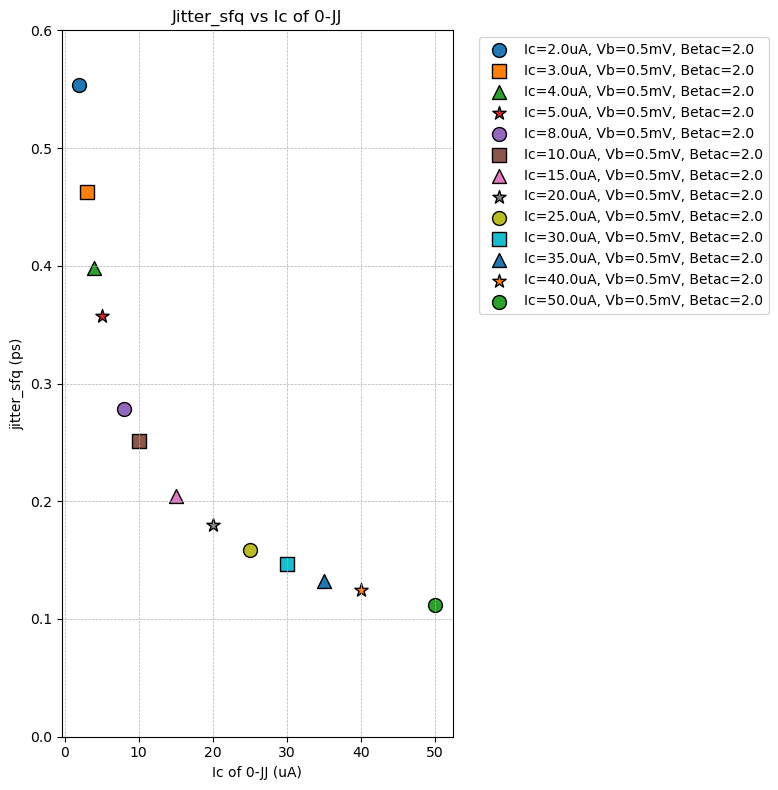

In [8]:
marker_styles = ['o', 's', '^', '*']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

fig = plt.figure(figsize=(8, 8))
for idx, row in xy_data.iterrows():
    marker_map = idx % len(marker_styles)
    # color_map = int(idx / int(len(xy_data)/len(lic_list)))
    if row["Vb"] == 0.50e-3:
        if row["Ic"] <= 50:
            plt.scatter(row["Ic"], row["Std"]*1e12, label=row["Name"],
                        marker=marker_styles[marker_map],
                        s=100,
                        # color = colors[color_map],
                        edgecolors='black',
                        alpha=1.0,
                        )
    
# plt.xlim(0, 35)
plt.ylim(0, 0.6)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title('Jitter_sfq vs Ic of 0-JJ')
plt.xlabel('Ic of 0-JJ (uA)')
plt.ylabel('jitter_sfq (ps)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.close()